**Nome:** Iran Freitas Ribeiro

**Matrícula:** 2021241588

**Disciplina:** TEI - Estatística Aplicada

**Professor:** Celso José Munaro

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import OLS, ccf
plt.style.use("seaborn")

In [3]:
# Leitura dos dados x, y
Z = pd.read_csv("Data_epc10.csv", sep=";", header=None)
Z = Z.values
Ztreino_R = Z[:300]
ZCC_treino = Z[300:600]
ZCC_normal = Z[600:1200]
ZCC_falha = Z[1200:]

A Figura $1$ mostra as variáveis $X$ e $Y$, como solicitado para realização das questões.

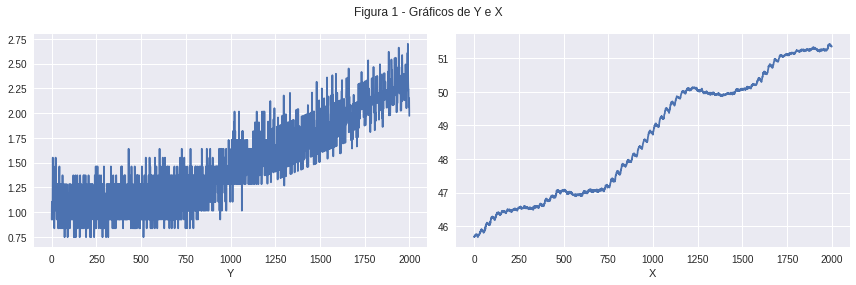

In [4]:
fig, ax = plt.subplots(figsize=(12,4), ncols=2)
ax[0].plot(Z[:, 1])
ax[0].set_xlabel("Y")
ax[1].plot(Z[:, 0])
ax[1].set_xlabel("X")
plt.suptitle("Figura 1 - Gráficos de Y e X")
plt.tight_layout()

# Questão 1

In [5]:
X1 = Ztreino_R[:, 0]
Y1 = Ztreino_R[:, 1]

Primeiramente, obtemos os parâmetros $\beta_0$ e $\beta_1$ usando os dados para treino do modelo `Ztreino_R`.

In [8]:
# treinamento do modelo
Xr = sm.add_constant(X1) # adiciona coluna com 1s
m1 = OLS(Y1, Xr)
res1 = m1.fit() # ajusta modelo nos dados
b0, b1 = res1.params # betas
b0, b1

(3.813347696735804, -0.058759323059980266)

Obtemos então $\beta_0 = 3.81$ e $\beta_1 \approx -0.059$

Após a obtenção dos parâmetros, obtemos os resíduos utilizando os dados em `ZCC_treino`.

In [7]:
# verificando o modelo com novos dados (ZCC_treino)
Xtreino = ZCC_treino[:, 0]
Ytreino = ZCC_treino[:, 1]
# obtenção dos resíduos usando os dados de ZCC_treino
y_hat = [(b0 + b1*xi) for xi in Xtreino]

A Figura $2$ verifica a reta gerada pelo modelo de regressão sobre o gráfico de dispersão dos dados `ZCC_treino`. Nota-se que, no gráfico de dispersão, que vários pontos em sequência acabam formando uma reta na horizontal, com um leve declive da esquerda para direita. A reta da regressão representa boa parte das retas dos dados em dispersão.

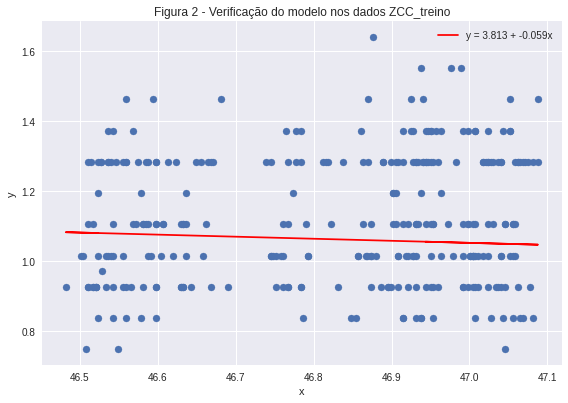

In [9]:
plt.scatter(Xtreino, Ytreino)
plt.plot(Xtreino, y_hat, c='red', label='y = {:.3f} + {:.3f}x'.format(b0, b1))
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.title("Figura 2 - Verificação do modelo nos dados ZCC_treino");

In [13]:
residuos_zc = [yi - yi_hat for yi, yi_hat in zip(Ytreino,y_hat)]
crus_corr = ccf(residuos_zc, residuos_zc, adjusted=False)

A Figura $3$ permite avaliar a normalidade e independência dos resíduos. A Figura $3$(a) mostra o gráfico de autocorrelação dos resíduos. Fica evidente que há uma correlação alta apenas quando o atraso é igual a $0$, logo os resíduos são independentes. A Figura $3$(b) mostra que o histograma dos resíduos aparentater uma disitribuição normal com média $\approx 0$. Por fim, a Figura $3$(c) mostra o normplot dos resíduos, evidenciando que, de fato, eles são normais.

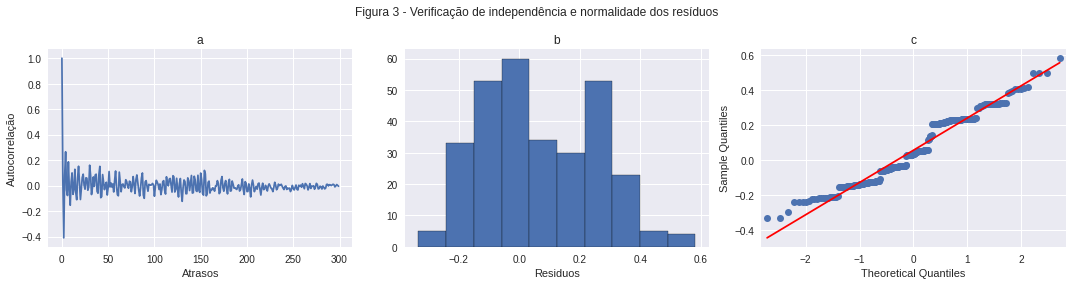

In [14]:
fig, ax = plt.subplots(figsize=(15,4), ncols=3)
ax[0].plot(crus_corr)
ax[1].hist(residuos_zc, edgecolor='black')
sm.qqplot(np.array(residuos_zc), line='s', ax=ax[2])
plt.suptitle("Figura 3 - Verificação de independência e normalidade dos resíduos")
ax[0].set_xlabel("Atrasos")
ax[0].set_ylabel("Autocorrelação")
ax[0].set_title("a")
ax[1].set_xlabel("Residuos")
ax[1].set_title("b")
ax[2].set_title("c")
plt.tight_layout();

# Questão 2

In [15]:
X2c = ZCC_treino[:, 0]
Y2c = ZCC_treino[:, 1]
b0, b1 = res1.params
# previsao de y usando X de ZCC_treino
Y_hat = [b0 + b1*xi for xi in X2c]

In [26]:
def controle(media, desvio, n, s=3):
    """
    Calcula o limite superior e inferior de uma carta de controle para a média conhecida
    """
    desvio_a = desvio/np.sqrt(n)
    ucl = media + s*desvio_a
    lcl = media - s*desvio_a
    return ucl, lcl

def c_media_desvio_desc(media_bar, d2, n, R_bar):
    """
    Limites de controle quando a media e desvio não são conhecidos
    """
    ucl = media_bar + 3/(d2*np.sqrt(n)) * R_bar
    lcl = media_bar - 3/(d2*np.sqrt(n)) * R_bar
    return ucl, lcl

def get_amostras(X, Y, n):
    """
    Seleciona amostras de tamanho n de X e Y
    """
    amostras_X = []
    amostras_Y = []
    i = 0
    while(i<len(X)):
        amostras_X.append(X[i:i+n])
        amostras_Y.append(Y[i:i+n])
        i = i+n
    return amostras_X, amostras_Y
    
def calc_media_desvio_residuos(amostrasX, amostrasY, b0, b1, n):
    """
    Calcula as médias e desvios dos resíduos
    """
    medias_residuos = []
    desvios_residuos= []
    for a_x, a_y in zip(amostrasX, amostrasY):
        if len(a_x)==n: # só executa caso a amostra tenha tamanho n
            y_hat_amostra = [b0 + b1*xi for xi in a_x]
            res_amostra = np.array(a_y) - np.array(y_hat_amostra)
            medias_residuos.append(res_amostra.mean())
            desvios_residuos.append(res_amostra.std())
    return medias_residuos, desvios_residuos

def testes_controle_media(X, Y, ns=[], mu_conhecido=False, mediac=0, stdc=1, params=[], R_bar=None):
    """
    Verifica as médias dentro dos limites para diferentes valores de n
    """
    b0, b1 = params
    ultrapassam = []
    nao_ultrapassam = []
    for i, n in enumerate(ns):
        amostras_X, amostras_Y = get_amostras(X, Y, n)
        if (mu_conhecido):
            ucl2, lcl2 = controle(mediac, stdc, n, s=6)
        else:
            ucl2, lcl2 = c_media_desvio_desc(mediac, stdc, n, R_bar)        
        medias_residuos = []
        medias_residuos, _ = calc_media_desvio_residuos(amostras_X, amostras_Y, b0, b1, n)
        medias_residuos = np.array(medias_residuos)
        dentro_intervalo = [1 for m in medias_residuos if (ucl2>m) and (m>lcl2)]    
        soma_dentro = sum(dentro_intervalo)
        nao_ultrapassam.append(soma_dentro)
        ultrapassam.append(len(medias_residuos) - soma_dentro)
    return ultrapassam, nao_ultrapassam

def FDR(TP, FP):
    return TP/(TP+FP)
def FAR(FN, TN):
    return FN/(FN+TN)

In [17]:
media_residuos, std_residuos = np.mean(residuos_zc), np.std(residuos_zc)

In [20]:
# X e Y dos dados normais
X_normal = ZCC_normal[:, 0]
Y_normal = ZCC_normal[:, 1]
# X e Y dos dados com falha
X_falha = ZCC_falha[:, 0]
Y_falha = ZCC_falha[:, 1]

Para verificar a influência do $n$ sobre os resultados de FDR e FAR, varia-se o $n=2, \dots, 60$. A obtenção das cartas de controle e verificação de quais amostras estão dentro do limite esperado são feitas pela função `testes_controle_media()`. Basicamente a função retorna uma lista com o número de amostras que ultrapassam os limites e uma lista com o número de amostras que não ultrapassam.

In [25]:
lista_n = np.arange(2,60)
ultrapassam_normal, n_ultrapassam_normal = testes_controle_media(X_normal, Y_normal, lista_n, mu_conhecido=True,mediac=media_residuos, stdc=std_residuos, params=[b0, b1])
ultrapassam_falha, n_ultrapassam_falha = testes_controle_media(X_falha, Y_falha, lista_n, mu_conhecido=True, mediac=media_residuos, stdc=std_residuos, params=[b0, b1])

- TP = True Positive: amostras de [1201, 2000] que ultrapassam o limiar\*100/800
- FP = False Positive: amostras de [601,1200] que ultrapassam o limiar\*100/600
- FN = False Negative: amostras de [1201, 2000] que não ultrapassam o limiar\*100/800
- TN = True negative: amostras de [601,1200] que não ultrapassam o limiar\*100/600

In [27]:
fdrs = [FDR(tp, fp) for tp,fp in zip(ultrapassam_falha, ultrapassam_normal)]
fars = [FAR(fn, tn) for fn, tn in zip(n_ultrapassam_falha, n_ultrapassam_normal)]

A Figura $4$ apresenta os gráficos de $FDR$ e $FAR$ para $n$ variando de $2$ a $60$. Nota-se que os valores de FDR tendem a diminuir à medida que aumenta-se o valor de $n$, oscilando por volta de $65\%$ e $70\%$ após $n=20$. Da mesma forma, os valores de FDA dominuem à medida que $n$ aumenta, estabilizando em $0.0\%$ após $n=4$.

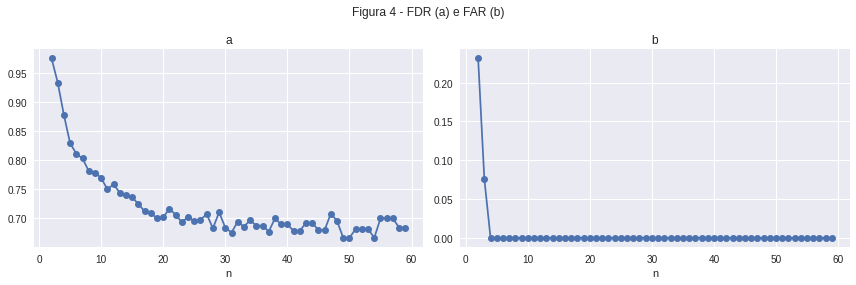

In [29]:
fig, ax = plt.subplots(figsize=(12,4), ncols=2)
ax[0].plot(lista_n, fdrs, marker='o')
ax[1].plot(lista_n, fars, marker='o')
ax[0].set_title("a")
ax[0].set_xlabel("n")
ax[1].set_xlabel("n")
ax[1].set_title("b")
plt.suptitle("Figura 4 - FDR (a) e FAR (b)")
plt.tight_layout();

In [31]:
fdrs[2]

0.8771929824561403

Como desejamos um $n$ que produza um FDR alto e um FDA baixo, podemos escolher $n=4$, onde o FDR é $\approx 88\%$ e o FDA é $0\%$. Assim: 

In [32]:
N = 4
ucl2, lcl2 = controle(media_residuos, std_residuos, N, s=6)
amostras_xnormal_c, amostras_ynormal_c = get_amostras(X_normal, Y_normal, N)
medias_normais_c, _ = calc_media_desvio_residuos(amostras_xnormal_c, amostras_ynormal_c, b0, b1, N)
amostras_xfalha_c, amostras_yfalha_c = get_amostras(X_falha, Y_falha, N)
medias_falha_c, _ = calc_media_desvio_residuos(amostras_xfalha_c, amostras_yfalha_c, b0, b1, N)

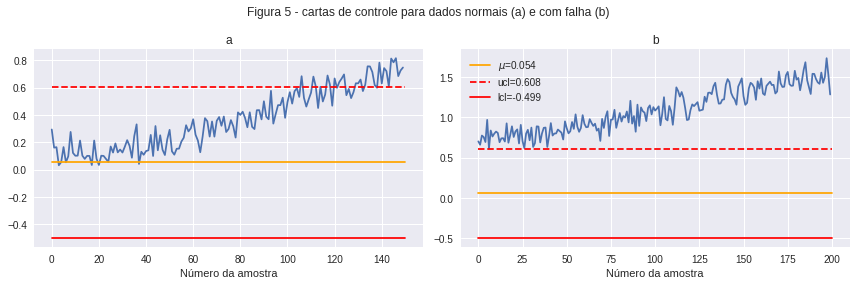

In [34]:
fig, ax = plt.subplots(figsize=(12,4), ncols=2)
x = np.arange(len(medias_normais_c))
ax[0].plot(x, medias_normais_c)
ax[0].plot([0, len(x)], [media_residuos, media_residuos], c='orange', label=r'$\mu$={:.3f}'.format(media_residuos))
ax[0].plot([0, len(x)], [ucl2, ucl2], ls='--', c='red', label='ucl={:.3f}'.format(ucl2))
ax[0].plot([0, len(x)], [lcl2, lcl2], c='red', label='lcl={:.3f}'.format(lcl2))
ax[0].set_title("a")
ax[0].set_xlabel("Número da amostra")

x = np.arange(len(medias_falha_c))
ax[1].plot(x, medias_falha_c)
ax[1].plot([0, len(x)], [media_residuos, media_residuos], c='orange', label=r'$\mu$={:.3f}'.format(media_residuos))
ax[1].plot([0, len(x)], [ucl2, ucl2], ls='--', c='red', label='ucl={:.3f}'.format(ucl2))
ax[1].plot([0, len(x)], [lcl2, lcl2], c='red', label='lcl={:.3f}'.format(lcl2))
ax[1].set_title("b")
ax[1].set_xlabel("Número da amostra")
plt.suptitle("Figura 5 - cartas de controle para dados normais (a) e com falha (b)")
plt.tight_layout()
plt.legend();

A Figura $5$ mostra que as cartas de controle conseguem identificar bem quando o processo está dentro dos limites de controle. Para os dados normais, por exemplo, apenas as amostras que estão mais próximas dos dados com falha que de acabam ultrapassando os limite definidos. Da mesma forma, a carta de controle não classifica nenhum dos dados com falha como dentro dos limites do controle.

# Questão 3

In [35]:
# separo as amostras de 10 em 10
amostras_xnormal_3, amostras_ynormal_3 = get_amostras(X_normal, Y_normal, 10)
medias_normais3, desvios_normais3 = calc_media_desvio_residuos(amostras_xnormal_3, amostras_ynormal_3, b0, b1, 10)
medias_normais3 = np.array(medias_normais3)
desvios_normais3 = np.array(desvios_normais3)

amostras_xfalha_3, amostras_yfalha_3 = get_amostras(X_falha, Y_falha, 10)
medias_falha3, desvios_falhas3 = calc_media_desvio_residuos(amostras_xfalha_3, amostras_yfalha_3, b0, b1, 10)
medias_falha3 = np.array(medias_falha3)
desvios_falhas3 = np.array(desvios_falhas3)

In [36]:
ms = [5, 10, 20]
medias_estimadas_normal = [np.mean(medias_normais3[:m]) for m in ms]
ranges_amostrais = [medias_normais3[:m].max() - medias_normais3[:m].min() for m in ms]
R_media_normal = np.mean(ranges_amostrais)

$\hat{\sigma} = \frac{\bar{R}}{d_2}$, pela Tabela $X$ no livro de referência, quando $n=10$, $d_2 = 3.078$, assim, podemos estimar o desvio padrão:

In [37]:
d2 = 3.078
desvio_normal = R_media_normal/d2
desvio_normal

0.046313316619498

In [38]:
lista_n = [10]
lista_ultrapassam_normal = []
lista_ultrapassam_falha = []
lista_nultrapassam_normal = []
lista_nultrapassam_falha = []
for m_n in medias_estimadas_normal:
    u_n, n_u_n = testes_controle_media(X_normal, Y_normal, lista_n, mu_conhecido=False, mediac=m_n, stdc=d2, params=[b0, b1], R_bar=R_media_normal)
    u_f, n_u_f = testes_controle_media(X_falha, Y_falha, lista_n, mu_conhecido=False, mediac=m_n, stdc=d2, params=[b0, b1], R_bar=R_media_normal)
    lista_ultrapassam_normal.append(u_n[0])
    lista_nultrapassam_normal.append(n_u_n[0])
    lista_ultrapassam_falha.append(u_f[0])
    lista_nultrapassam_falha.append(n_u_f[0])

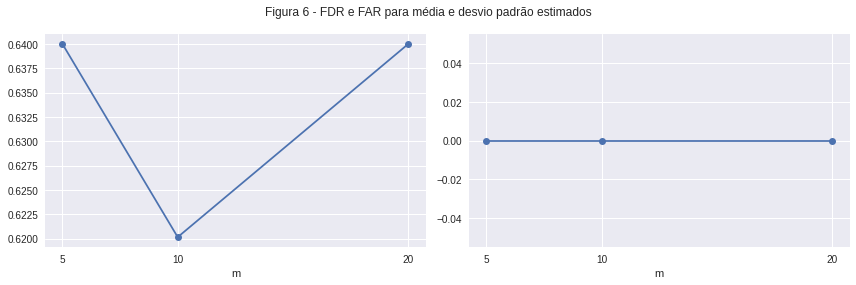

In [40]:
fdrs = [FDR(tp, fp) for tp,fp in zip(lista_ultrapassam_falha, lista_ultrapassam_normal)]
fars = [FAR(fn,tn) for fn, tn in zip(lista_nultrapassam_falha, lista_nultrapassam_normal)]
fig, ax = plt.subplots(figsize=(12,4), ncols=2)
ax[0].plot(ms, fdrs, marker='o')
ax[1].plot(ms, fars, marker='o')
ax[0].set_xlabel("m")
ax[0].set_xticks([5, 10, 20])
ax[1].set_xlabel("m")
plt.suptitle("Figura 6 - FDR e FAR para média e desvio padrão estimados")
plt.xticks(ms)
plt.tight_layout();

In [41]:
ucl2, lcl2 = c_media_desvio_desc(medias_estimadas_normal[0], d2, 10, R_media_normal)

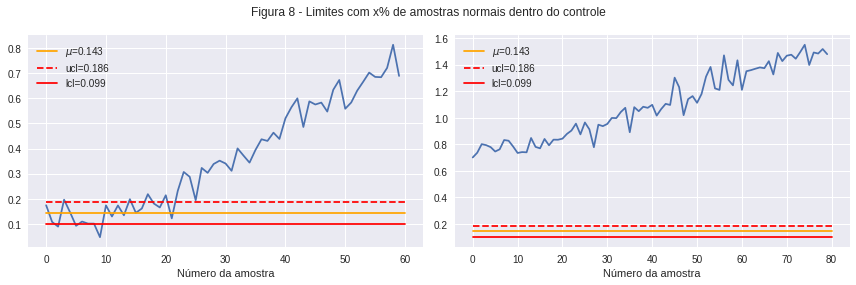

In [43]:
fig, ax = plt.subplots(figsize=(12,4), ncols=2)
x = np.arange(len(medias_normais3))
mu = medias_estimadas_normal[0]
ax[0].plot(x, medias_normais3)
ax[0].plot([0, len(x)], [mu, mu], c='orange', label=r'$\mu$={:.3f}'.format(mu))
ax[0].plot([0, len(x)], [ucl2, ucl2], ls='--', c='red', label='ucl={:.3f}'.format(ucl2))
ax[0].plot([0, len(x)], [lcl2, lcl2], c='red', label='lcl={:.3f}'.format(lcl2))
ax[0].legend()
ax[0].set_xlabel("Número da amostra")
x = np.arange(len(medias_falha3))
ax[1].plot(x, medias_falha3)
ax[1].plot([0, len(x)], [mu, mu], c='orange', label=r'$\mu$={:.3f}'.format(mu))
ax[1].plot([0, len(x)], [ucl2, ucl2], ls='--', c='red', label='ucl={:.3f}'.format(ucl2))
ax[1].plot([0, len(x)], [lcl2, lcl2], c='red', label='lcl={:.3f}'.format(lcl2))
# plt.title("Figura 6 - x% de amostras com falha fora dos limites")
ax[1].set_xlabel("Número da amostra")
ax[1].legend()
plt.suptitle("Figura 7 - Limites com x% de amostras normais dentro do controle")
plt.tight_layout()
plt.legend();

# Questão 4

In [1]:
def controle_desvio(sbar, c4):
    UCL = sbar + 3 * sbar/c4 * np.sqrt(1 - c4**2)
    LCL = sbar - 3 * sbar/c4 * np.sqrt(1 - c4**2)
    return UCL, LCL

In [48]:
len(desvios_normais3)

60

In [45]:
medias_desvios = [np.mean(desvios_normais3[:m]) for m in ms]

In [35]:
def testes_controle_desvio(X, Y, ns=[], sbar=0, c4=0.99, params=[]):
    b0, b1 = params
    ultrapassam = []
    nao_ultrapassam = []
    for i, n in enumerate(ns):
        amostras_X, amostras_Y = get_amostras(X, Y, n)
        ucl2, lcl2 = controle_desvio(sbar, c4)
        _, desvios_residuos = calc_media_desvio_residuos(amostras_X, amostras_Y, b0, b1, n)
        # medias_residuos = np.array(medias_residuos)
        dentro_intervalo = [1 for s in desvios_residuos if (ucl2>s) and (s>lcl2)]    
        soma_dentro = sum(dentro_intervalo)
        nao_ultrapassam.append(soma_dentro)
        ultrapassam.append(len(desvios_residuos) - soma_dentro)
    return ultrapassam, nao_ultrapassam

In [36]:
lista_n = [10]
lista_ultrapassam_normal = []
lista_ultrapassam_falha = []
lista_nultrapassam_normal = []
lista_nultrapassam_falha = []
for sbar_i in medias_desvios:
    u_n, n_u_n = testes_controle_desvio(X_normal, Y_normal, lista_n, sbar=sbar_i, params=[b0, b1])
    u_f, n_u_f = testes_controle_desvio(X_falha, Y_falha, lista_n, sbar=sbar_i, params=[b0, b1])
    lista_ultrapassam_normal.append(u_n[0])
    lista_nultrapassam_normal.append(n_u_n[0])
    lista_ultrapassam_falha.append(u_f[0])
    lista_nultrapassam_falha.append(n_u_f[0])

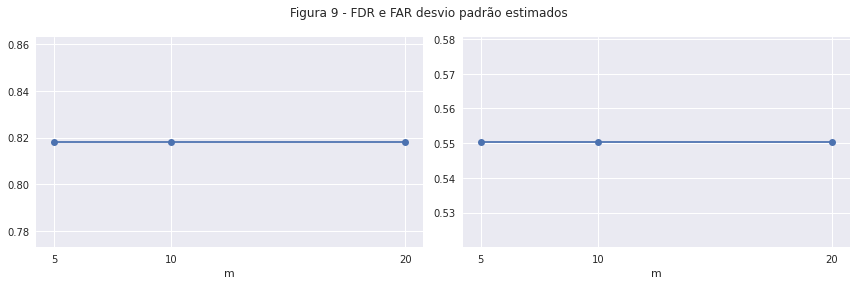

In [39]:
fdrs = [FDR(tp, fp) for tp,fp in zip(lista_ultrapassam_falha, lista_ultrapassam_normal)]
fars = [FAR(fn,tn) for fn, tn in zip(lista_nultrapassam_falha, lista_nultrapassam_normal)]
fig, ax = plt.subplots(figsize=(12,4), ncols=2)
ax[0].plot(ms, fdrs, marker='o')
ax[1].plot(ms, fars, marker='o')
ax[0].set_xlabel("m")
ax[0].set_xticks([5, 10, 20])
ax[1].set_xlabel("m")
plt.suptitle("Figura 8 - FDR e FAR desvio padrão estimados")
plt.xticks(ms)
plt.tight_layout();

# Questão 5

A questão pede a soma cumulativa dos resíduos. Como o resultado será comparado com as questões 3 e 4...

In [58]:
desvios_normais3.std()

0.03915559178590205

In [61]:
desvios_normais3

array([0.20385026, 0.16958291, 0.20017399, 0.20781159, 0.1992759 ,
       0.19250898, 0.16975917, 0.17072104, 0.20815626, 0.1290014 ,
       0.18793218, 0.2280694 , 0.20754816, 0.15342619, 0.2267118 ,
       0.19358132, 0.11990847, 0.2104533 , 0.18620615, 0.17174946,
       0.18441507, 0.16971904, 0.12146124, 0.19555686, 0.12900245,
       0.1193466 , 0.16544449, 0.16847113, 0.1502094 , 0.13444397,
       0.16037384, 0.13666061, 0.07992214, 0.19555688, 0.22586752,
       0.15840989, 0.13302841, 0.18803799, 0.12737886, 0.12995694,
       0.11933923, 0.23268464, 0.23590189, 0.17174621, 0.23425949,
       0.16094512, 0.25680056, 0.12883601, 0.14044925, 0.09006011,
       0.13589181, 0.13027539, 0.138412  , 0.1647389 , 0.22653697,
       0.19127946, 0.14104302, 0.17968066, 0.18135505, 0.11578574])

In [65]:
# usando a média dos resíduos
m5 = (desvios_normais3 - media_residuos).cumsum()
m5_falha = (desvios_falhas3 - media_residuos).cumsum()
# m10 = (desvios_normais3 - medias_desvios[1]).cumsum()
# m20 = (desvios_normais3 - medias_desvios[2]).cumsum()

In [64]:
media_residuos

0.05431538676207395

In [68]:
y_hat_normal = [b0 + b1*xi for xi in X_normal]
res = np.array(Y_normal) - np.array(y_hat_normal)

In [69]:
medias_desvios

[0.19613892925742982, 0.18508415007407897, 0.18682139624104271]

In [72]:
# usando dados individuais
m5 = (res - media_residuos).cumsum()

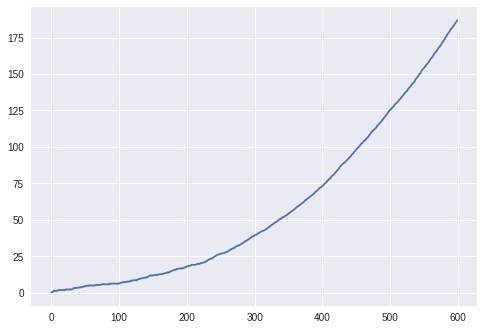

In [73]:
plt.plot(m5)
# plt.plot(m5_falha)

# Anexo (Funções construídas)